# Version 1 of the Model - Architecture Fully Connected Neural Network

## Imports

In [3]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from keras.utils import to_categorical
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import transformers
import numpy as np
import warnings
import spacy
import math
import nltk

In [26]:
warnings.filterwarnings('ignore')
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


## Loading the Datasets

In [27]:
# Loading training data
training_data = pd.read_csv('dados_treino.txt', header=None, delimiter=';')

# Loading test data
training_test = pd.read_csv('dados_teste.txt', header=None, delimiter=';')

# Adjusting column names
training_data = training_data.rename(columns={0:'text', 1:'feeling'})
training_test = training_test.rename(columns={0:'text', 1:'feeling'})

In [28]:
# Looking at the shape of the data
print('Training: ', training_data.shape)
print('Test: ', training_test.shape)

Training:  (16000, 2)
Test:  (2000, 2)


In [29]:
# Feelings present in training data
print('Data of training ', training_data['feeling'].value_counts())
# Sentimentos presentes nos dados de teste
print('Data of test', training_test['feeling'].value_counts())


Data of training  feeling
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64
Data of test feeling
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


## Text data pre-processing

In [30]:
# Downloading the dictionary to simplify the text
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [31]:
# Loading the dictionary
dict_nlp = spacy.load('en_core_web_md')

In [32]:
# Creating a function that will receive text as a parameter to be "simplified"
def simplifies_text(text):
    
    # Process the text using the dictionary
    doc = dict_nlp(text)

    # Creates a list of lemmas from the tokens, converted to lowercase and without whitespace,
    # And excluding words that are stopwords
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    # Returns the processed tokens as a single string, joining them with spaces
    return ' '.join(tokens)

In [33]:
# Applying the function to training data
training_data['processed_text'] = training_data['text'].apply(simplifies_text)

# Applying the function to test data
training_test['processed_text'] = training_test['text'].apply(simplifies_text)

# Viewing the data
training_data.head()

,text,feeling,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


## Vectorization with TF-IDF

In [34]:
# Create the vectorizer
vec_tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [35]:
# Applying the vectorizer to both training and testing data
training_data_tfidf = vec_tfidf.fit_transform(training_data['processed_text'])
training_test_tfidf = vec_tfidf.transform(training_test['processed_text'])

In [36]:
print('shape: ', training_data_tfidf.shape)
print('Type: ', type(training_data_tfidf))

shape:  (16000, 5586)
Type:  <class 'scipy.sparse._csr.csr_matrix'>


In [37]:
# Converting data from scipy matrix (sparse matrix) to array type
X_training_array = training_data_tfidf.toarray()
X_test_array = training_test_tfidf.toarray()

## Target data preparation

In [38]:
# Create the Label Enconder
enc_le = LabelEncoder()

In [39]:
# Performs the fit (training) and transforms it into the target variable in training
y_training_le = enc_le.fit_transform(training_data['feeling'])

# Transforms into the target variable in training
y_test_le = enc_le.transform(training_test['feeling'])

In [40]:
# Modifying the weights between Classes
weights_classes = compute_class_weight('balanced', classes = np.unique(y_training_le), y = y_training_le)

# Now the weights are a Numpy array

In [41]:
# Division into Training and Test Data (Validation)
X_training, X_val, y_training, y_val = train_test_split(X_training_array, 
                                                    y_training_le, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y_training_le)

In [42]:
# Sets target variable as categorical type
y_training_encoded = to_categorical(y_training)
y_test_encoded = to_categorical(y_test_le)
y_val_encoded = to_categorical(y_val)

In [43]:
# Shape

y_training_encoded.shape, y_test_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

## Model Construction

In [44]:
# Initializes a sequential model. Sequential models are a linear stack of layers.
model_FCNN = Sequential() 

# Adds the first dense (fully-connected) layer to the model
model_FCNN.add(Dense(4096, 
                        
                        # Use the activation function SELU (Scaled Exponential Linear Unit)
                        activation = 'selu',  
                        
                        # Initializes the weights with the normal LeCun distribution
                        kernel_initializer = 'lecun_normal',  
                        
                        # Defines the input format based on the number of features in X_training
                        input_shape = (X_training.shape[1],),  
                        
                        # Apply L2 regularization to reduce overfitting
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adds the second dense layer
model_FCNN.add(Dense(2048, 
                        activation = 'selu',  
                        kernel_initializer = 'lecun_normal',  
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adds the third dense layer
model_FCNN.add(Dense(1024, 
                        activation = 'selu',  
                        kernel_initializer = 'lecun_normal',  
                        kernel_regularizer = tf.keras.regularizers.l2(0.1)))  

# Adds the fourth dense layer
# Layer with 64 neurons and SELU activation
model_FCNN.add(Dense(64, activation = 'selu',))  

# Adds the output layer
# Output layer with 6 neurons and softmax activation for multiclass classification
model_FCNN.add(Dense(6, activation = 'softmax'))                    

- ## Model Compilation and Summary

In [45]:
# Assigns specific weights to the bias vector of the last layer of the model
model_FCNN.layers[-1].bias.assign(weights_classes)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [73]:
# Compile the model
# Set the optimizer to 'Adam'.
# Set the loss function to 'categorical_crossentropy'. It is suitable for classification problems
# multiclass, where labels are provided in a one-hot encoded format.
model_FCNN.compile(optimizer = 'Adam',  
                      loss = tf.losses.categorical_crossentropy,  
                      metrics = ['accuracy', Precision(), Recall(), AUC()])  

In [74]:
model_FCNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4096)              22884352  
                                                                 
 dense_6 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 64)                65600     
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33439174 (127.56 MB)
Trainable params: 33439174 (127.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Callbacks end Early Stopping

In [49]:
# Function for learning rate scheduler parameters
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

In [50]:
# Learning Rate Scheduler
lr_scheduler = LearningRateScheduler(step_decay)

# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 3)

## Model Training

In [51]:
# Some Hyperparameters
num_epochs = 20
v_batch_size = 256

In [52]:
history = model_FCNN.fit(X_training, 
                            y_training_encoded, 
                            validation_data = (X_val, y_val_encoded), 
                            epochs = num_epochs, 
                            batch_size = v_batch_size, 
                            callbacks = [early_stopping, lr_scheduler])

Epoch 1/20


50/50 [==============================] - 11s 205ms/step - loss: 37.0992 - accuracy: 0.6724 - val_loss: 2.2401 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 10s 196ms/step - loss: 1.4822 - accuracy: 0.7941 - val_loss: 1.3249 - val_accuracy: 0.8159 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 10s 203ms/step - loss: 1.1899 - accuracy: 0.8260 - val_loss: 1.2237 - val_accuracy: 0.8153 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 10s 208ms/step - loss: 1.0670 - accuracy: 0.8531 - val_loss: 1.1740 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 10s 204ms/step - loss: 0.9437 - accuracy: 0.8777 - val_loss: 1.0794 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 10s 200ms/step - loss: 0.8845 - accuracy: 0.8944 - val_loss: 1.0989 - val_accuracy: 0.8306 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 10s 204ms

## Model Assessment

In [53]:
# Extract the error in training and validation
loss, val_loss = history.history['loss'], history.history['val_loss']

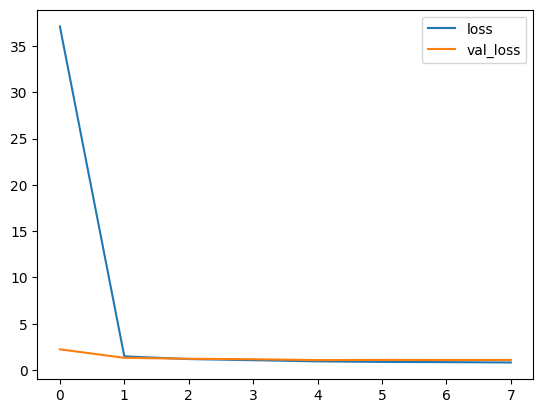

In [54]:
# Plot
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [55]:
# Predictions with test data
prediction_v1 = model_FCNN.predict(X_test_array)

# Extrai os labels
prediction_v1_labels = prediction_v1.argmax(axis=1)
print(classification_report(y_test_le, prediction_v1_labels))

63/63 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       275
           1       0.77      0.87      0.82       224
           2       0.86      0.90      0.88       695
           3       0.75      0.57      0.65       159
           4       0.87      0.86      0.87       581
           5       0.84      0.39      0.54        66

    accuracy                           0.83      2000
   macro avg       0.81      0.74      0.76      2000
weighted avg       0.83      0.83      0.83      2000



In [56]:
print(confusion_matrix(y_test_le, prediction_v1_labels))

[[234   9   7   2  23   0]
 [  9 195   4   0  13   3]
 [ 10  10 623  26  25   1]
 [  9   4  44  91  10   1]
 [ 32  13  34   2 500   0]
 [  1  23  11   1   4  26]]


In [57]:
# Save the model
model_FCNN.save('model_FCNN.keras')

## Deploy FCNN

In [58]:
# Load the saved model
model_v1_load = load_model('model_FCNN.keras')

In [71]:
# New phrase for deploy (feeling = Fear)
phrase = "I'm a little scared"

# Creates a Pandas dataframe with the phrase
df_phrase = pd.DataFrame({'phrase':[phrase]})

# Applies the processing function
df_phrase['Processed_phrase'] = df_phrase['phrase'].apply(simplifies_text)

In [72]:
# Apply vectorization
df_phrase_tfidf = vec_tfidf.transform(df_phrase['Processed_phrase'])

# Transforms the spicy matrix into an array
df_phrase_array = df_phrase_tfidf.toarray()

# Prediction
prediction = model_v1_load.predict(df_phrase_array)

# Select the class with the highest probability
class_largest_prob = np.argmax(prediction, axis=1)

# Gets the class name
class_name = enc_le.inverse_transform(class_largest_prob)

# Predicted class
print('Predicted class: ', class_name)

1/1 [==============================] - 0s 19ms/step
Predicted class:  ['fear']
